<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/T-SMOTE/blob/main/T_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1: Create dummy dataset

In [75]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)
rng = np.random.RandomState(42)


# Positive samples (3 subjects, 10 timesteps, 2 features)
P = np.array([
    np.column_stack([np.linspace(0.2, 1.2, 10), np.linspace(0.1, 0.9, 10)]) + rng.normal(0, 0.03, (10,2)),
    np.column_stack([np.linspace(0.3, 1.1, 10), np.linspace(0.2, 1.0, 10)]) + rng.normal(0, 0.03, (10,2)),
    np.column_stack([np.linspace(0.25, 1.05, 10), np.linspace(0.15, 0.95, 10)]) + rng.normal(0, 0.03, (10,2)),
])

# Negative samples (6 subjects, 10 timesteps, 2 features)
N = np.array([
    np.column_stack([np.linspace(0.2, 0.5, 10), np.linspace(0.1, 0.4, 10)]) + rng.normal(0, 0.02, (10,2)),
    np.column_stack([np.linspace(0.15, 0.45, 10), np.linspace(0.1, 0.35, 10)]) + rng.normal(0, 0.02, (10,2)),
    np.column_stack([np.linspace(0.25, 0.5, 10), np.linspace(0.2, 0.45, 10)]) + rng.normal(0, 0.02, (10,2)),
    np.column_stack([np.linspace(0.22, 0.48, 10), np.linspace(0.12, 0.42, 10)]) + rng.normal(0, 0.02, (10,2)),
    np.column_stack([np.linspace(0.18, 0.44, 10), np.linspace(0.09, 0.38, 10)]) + rng.normal(0, 0.02, (10,2)),
    np.column_stack([np.linspace(0.2, 0.46, 10), np.linspace(0.1, 0.36, 10)]) + rng.normal(0, 0.02, (10,2)),
])
print("Positive:", P.shape, "Negative:", N.shape)

Positive: (3, 10, 2) Negative: (6, 10, 2)


In [76]:
P


array([[[0.215, 0.096],
        [0.331, 0.235],
        [0.415, 0.271],
        [0.581, 0.39 ],
        [0.63 , 0.472],
        [0.742, 0.53 ],
        [0.874, 0.576],
        [0.926, 0.705],
        [1.059, 0.821],
        [1.173, 0.858]],

       [[0.344, 0.193],
        [0.391, 0.246],
        [0.461, 0.381],
        [0.532, 0.478],
        [0.638, 0.547],
        [0.726, 0.7  ],
        [0.833, 0.702],
        [0.947, 0.786],
        [1.017, 0.852],
        [1.06 , 1.006]],

       [[0.272, 0.155],
        [0.335, 0.23 ],
        [0.383, 0.306],
        [0.503, 0.448],
        [0.616, 0.453],
        [0.704, 0.583],
        [0.763, 0.702],
        [0.903, 0.8  ],
        [0.936, 0.852],
        [1.06 , 0.979]]])

# STEP 2: Define window extraction

In [77]:
w = 4  # window length
T = 10

def make_window(seq, l, w):
    start = T - l - w
    end = T - l
    if start < 0 or end > T or start >= end:
        return None
    return seq[start:end, :]


# STEP 3: Build base classifier using l=0 windows

In [78]:
P_l0 = np.array([make_window(seq, 0, w) for seq in P])
N_l0 = np.array([make_window(seq, 0, w) for seq in N])
P_l0,N_l0

(array([[[0.874, 0.576],
         [0.926, 0.705],
         [1.059, 0.821],
         [1.173, 0.858]],
 
        [[0.833, 0.702],
         [0.947, 0.786],
         [1.017, 0.852],
         [1.06 , 1.006]],
 
        [[0.763, 0.702],
         [0.903, 0.8  ],
         [0.936, 0.852],
         [1.06 , 0.979]]]),
 array([[[0.399, 0.331],
         [0.381, 0.35 ],
         [0.468, 0.361],
         [0.502, 0.36 ]],
 
        [[0.336, 0.26 ],
         [0.375, 0.265],
         [0.423, 0.327],
         [0.45 , 0.345]],
 
        [[0.418, 0.416],
         [0.441, 0.4  ],
         [0.472, 0.399],
         [0.523, 0.465]],
 
        [[0.372, 0.329],
         [0.404, 0.384],
         [0.435, 0.38 ],
         [0.496, 0.395]],
 
        [[0.34 , 0.288],
         [0.388, 0.301],
         [0.448, 0.357],
         [0.416, 0.393]],
 
        [[0.372, 0.28 ],
         [0.408, 0.319],
         [0.431, 0.36 ],
         [0.455, 0.414]]]))

In [79]:
X_pos = P_l0.reshape(len(P_l0), -1)
X_neg = N_l0.reshape(len(N_l0), -1)
X_pos,X_neg

(array([[0.874, 0.576, 0.926, 0.705, 1.059, 0.821, 1.173, 0.858],
        [0.833, 0.702, 0.947, 0.786, 1.017, 0.852, 1.06 , 1.006],
        [0.763, 0.702, 0.903, 0.8  , 0.936, 0.852, 1.06 , 0.979]]),
 array([[0.399, 0.331, 0.381, 0.35 , 0.468, 0.361, 0.502, 0.36 ],
        [0.336, 0.26 , 0.375, 0.265, 0.423, 0.327, 0.45 , 0.345],
        [0.418, 0.416, 0.441, 0.4  , 0.472, 0.399, 0.523, 0.465],
        [0.372, 0.329, 0.404, 0.384, 0.435, 0.38 , 0.496, 0.395],
        [0.34 , 0.288, 0.388, 0.301, 0.448, 0.357, 0.416, 0.393],
        [0.372, 0.28 , 0.408, 0.319, 0.431, 0.36 , 0.455, 0.414]]))

## Spy setup (15% of negatives -> 1 spy)

In [80]:

spy_idx = [0]
X_spy = X_neg[spy_idx]
y_spy = np.ones(len(spy_idx))

mask = np.ones(len(X_neg), bool)
mask[spy_idx] = False
X_neg_rem = X_neg[mask]

mask,X_neg_rem

(array([False,  True,  True,  True,  True,  True]),
 array([[0.336, 0.26 , 0.375, 0.265, 0.423, 0.327, 0.45 , 0.345],
        [0.418, 0.416, 0.441, 0.4  , 0.472, 0.399, 0.523, 0.465],
        [0.372, 0.329, 0.404, 0.384, 0.435, 0.38 , 0.496, 0.395],
        [0.34 , 0.288, 0.388, 0.301, 0.448, 0.357, 0.416, 0.393],
        [0.372, 0.28 , 0.408, 0.319, 0.431, 0.36 , 0.455, 0.414]]))

In [81]:
# Combine into spy-injected positives and remaining negatives
X_Pprime = np.vstack([X_pos, X_spy])
y_Pprime = np.hstack([np.ones(len(X_pos)), np.ones(len(spy_idx))])
X_Nprime = X_neg_rem
y_Nprime = np.zeros(len(X_Nprime))

# Balance dataset
if len(X_Pprime) < len(X_Nprime):
    X_Pprime_bal, y_Pprime_bal = resample(X_Pprime, y_Pprime,
                                          replace=True, n_samples=len(X_Nprime), random_state=42)
    X_train = np.vstack([X_Pprime_bal, X_Nprime])
    y_train = np.hstack([y_Pprime_bal, y_Nprime])
else:
    X_Nprime_bal, y_Nprime_bal = resample(X_Nprime, y_Nprime,
                                          replace=True, n_samples=len(X_Pprime), random_state=42)
    X_train = np.vstack([X_Pprime, X_Nprime_bal])
    y_train = np.hstack([y_Pprime, y_Nprime_bal])


X_train,y_train

(array([[0.763, 0.702, 0.903, 0.8  , 0.936, 0.852, 1.06 , 0.979],
        [0.399, 0.331, 0.381, 0.35 , 0.468, 0.361, 0.502, 0.36 ],
        [0.874, 0.576, 0.926, 0.705, 1.059, 0.821, 1.173, 0.858],
        [0.763, 0.702, 0.903, 0.8  , 0.936, 0.852, 1.06 , 0.979],
        [0.763, 0.702, 0.903, 0.8  , 0.936, 0.852, 1.06 , 0.979],
        [0.336, 0.26 , 0.375, 0.265, 0.423, 0.327, 0.45 , 0.345],
        [0.418, 0.416, 0.441, 0.4  , 0.472, 0.399, 0.523, 0.465],
        [0.372, 0.329, 0.404, 0.384, 0.435, 0.38 , 0.496, 0.395],
        [0.34 , 0.288, 0.388, 0.301, 0.448, 0.357, 0.416, 0.393],
        [0.372, 0.28 , 0.408, 0.319, 0.431, 0.36 , 0.455, 0.414]]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]))

In [82]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

spy_proba = clf.predict_proba(X_spy)[:, 1]
h = float(np.max(spy_proba))
print(f"\nSpy probability={spy_proba[0]:.3f} → threshold h={h:.3f}")
print(clf.predict_proba(X_spy)),X_spy



Spy probability=0.332 → threshold h=0.332
[[0.668 0.332]]


(None, array([[0.399, 0.331, 0.381, 0.35 , 0.468, 0.361, 0.502, 0.36 ]]))

In [83]:
print(P)

[[[0.215 0.096]
  [0.331 0.235]
  [0.415 0.271]
  [0.581 0.39 ]
  [0.63  0.472]
  [0.742 0.53 ]
  [0.874 0.576]
  [0.926 0.705]
  [1.059 0.821]
  [1.173 0.858]]

 [[0.344 0.193]
  [0.391 0.246]
  [0.461 0.381]
  [0.532 0.478]
  [0.638 0.547]
  [0.726 0.7  ]
  [0.833 0.702]
  [0.947 0.786]
  [1.017 0.852]
  [1.06  1.006]]

 [[0.272 0.155]
  [0.335 0.23 ]
  [0.383 0.306]
  [0.503 0.448]
  [0.616 0.453]
  [0.704 0.583]
  [0.763 0.702]
  [0.903 0.8  ]
  [0.936 0.852]
  [1.06  0.979]]]


# STEP 4: Slide leading time l to compute mean score S_l

In [84]:
S_l = []
buckets = {}
l = 0
while True:
    scores = []
    for i, seq in enumerate(P):
        # print(i)
        print(seq.shape)
        wseq = make_window(seq, l, w) # window segment
        if wseq is not None:
          print(wseq.reshape(1,-1))
        if wseq is None:
            break
        score = clf.predict_proba(wseq.reshape(1, -1))[:, 1].item()
        scores.append(score)
        buckets.setdefault(l, []).append({"id": i, "window": wseq, "score": score})

    print(len(scores), len(P))
    if len(scores) != len(P):
        print("breaking l:",l)
        print(len(scores), len(P))
        break
    mean_score = np.mean(scores)
    S_l.append((l, mean_score))
    l += 1
print(S_l)


(10, 2)
[[0.874 0.576 0.926 0.705 1.059 0.821 1.173 0.858]]
(10, 2)
[[0.833 0.702 0.947 0.786 1.017 0.852 1.06  1.006]]
(10, 2)
[[0.763 0.702 0.903 0.8   0.936 0.852 1.06  0.979]]
3 3
(10, 2)
[[0.742 0.53  0.874 0.576 0.926 0.705 1.059 0.821]]
(10, 2)
[[0.726 0.7   0.833 0.702 0.947 0.786 1.017 0.852]]
(10, 2)
[[0.704 0.583 0.763 0.702 0.903 0.8   0.936 0.852]]
3 3
(10, 2)
[[0.63  0.472 0.742 0.53  0.874 0.576 0.926 0.705]]
(10, 2)
[[0.638 0.547 0.726 0.7   0.833 0.702 0.947 0.786]]
(10, 2)
[[0.616 0.453 0.704 0.583 0.763 0.702 0.903 0.8  ]]
3 3
(10, 2)
[[0.581 0.39  0.63  0.472 0.742 0.53  0.874 0.576]]
(10, 2)
[[0.532 0.478 0.638 0.547 0.726 0.7   0.833 0.702]]
(10, 2)
[[0.503 0.448 0.616 0.453 0.704 0.583 0.763 0.702]]
3 3
(10, 2)
[[0.415 0.271 0.581 0.39  0.63  0.472 0.742 0.53 ]]
(10, 2)
[[0.461 0.381 0.532 0.478 0.638 0.547 0.726 0.7  ]]
(10, 2)
[[0.383 0.306 0.503 0.448 0.616 0.453 0.704 0.583]]
3 3
(10, 2)
[[0.331 0.235 0.415 0.271 0.581 0.39  0.63  0.472]]
(10, 2)
[[0.391 0.24

In [85]:
buckets[0][0],buckets[1][0]

({'id': 0,
  'window': array([[0.874, 0.576],
         [0.926, 0.705],
         [1.059, 0.821],
         [1.173, 0.858]]),
  'score': 0.7635485214928704},
 {'id': 0,
  'window': array([[0.742, 0.53 ],
         [0.874, 0.576],
         [0.926, 0.705],
         [1.059, 0.821]]),
  'score': 0.6920618662773941})

In [86]:
buckets.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])


Mean scores by l:
  l=0: mean S_l=0.766
  l=1: mean S_l=0.699
  l=2: mean S_l=0.623
  l=3: mean S_l=0.541
  l=4: mean S_l=0.455
  l=5: mean S_l=0.370
  l=6: mean S_l=0.298
Chosen L=5


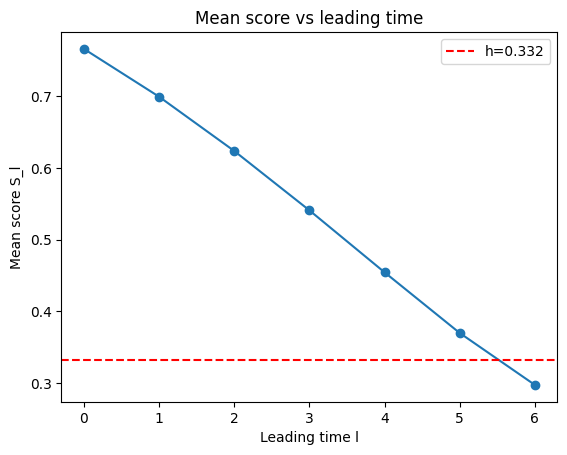

In [87]:

L = None
for l_val, mean_score in S_l:
    if mean_score < h:
        L = l_val - 1
        break
if L is None:
    L = S_l[-1][0]

print("\nMean scores by l:")
for l_val, mean_score in S_l:
    print(f"  l={l_val}: mean S_l={mean_score:.3f}")
print(f"Chosen L={L}")

plt.plot([x[0] for x in S_l], [x[1] for x in S_l], marker='o')
plt.axhline(y=h, color='r', linestyle='--', label=f"h={h:.3f}")
plt.title("Mean score vs leading time")
plt.xlabel("Leading time l")
plt.ylabel("Mean score S_l")
plt.legend()
plt.show()

In [88]:
def sample_beta(a, b, size=1):
    Xg = np.random.gamma(a, 1, size)
    # print("Xg",Xg)
    Yg = np.random.gamma(b, 1, size)
    # print("Yg",Yg)
    return Xg / (Xg + Yg)

# STEP 5: Show example of synthetic temporal mixing

alphas [0.631 0.86  0.753]

Original windows (subject 0):
W0 (l=0):
 [[0.874 0.576]
 [0.926 0.705]
 [1.059 0.821]
 [1.173 0.858]]
W1 (l=1):
 [[0.742 0.53 ]
 [0.874 0.576]
 [0.926 0.705]
 [1.059 0.821]]

Synthetic #1: alpha=0.631, s_new=0.737, weight=0.405
[[0.825 0.559]
 [0.907 0.658]
 [1.01  0.778]
 [1.131 0.844]]

Synthetic #2: alpha=0.860, s_new=0.754, weight=0.422
[[0.855 0.57 ]
 [0.919 0.687]
 [1.04  0.804]
 [1.157 0.852]]

Synthetic #3: alpha=0.753, s_new=0.746, weight=0.414
[[0.841 0.565]
 [0.913 0.673]
 [1.026 0.792]
 [1.145 0.848]]


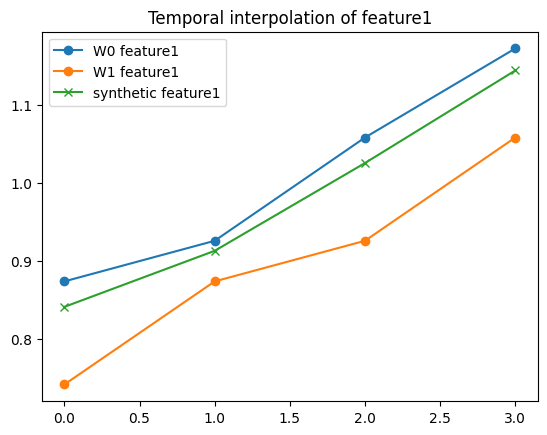

In [89]:
if L >= 1:
    subj = 0
    W0 = buckets[0][subj]["window"]
    W1 = buckets[1][subj]["window"]
    s0 = buckets[0][subj]["score"]
    s1 = buckets[1][subj]["score"]

    alphas = sample_beta(s0, s1, 3)
    print("alphas",alphas)
    print("\nOriginal windows (subject 0):")
    print("W0 (l=0):\n", np.round(W0, 3))
    print("W1 (l=1):\n", np.round(W1, 3))

    for idx, alpha in enumerate(alphas, 1):
        X_new = alpha * W0 + (1 - alpha) * W1
        s_new = alpha * s0 + (1 - alpha) * s1
        w_weight = max(0.0, s_new - h)
        print(f"\nSynthetic #{idx}: alpha={alpha:.3f}, s_new={s_new:.3f}, weight={w_weight:.3f}")
        print(np.round(X_new, 3))

    plt.plot(W0[:, 0], label="W0 feature1", marker='o')
    plt.plot(W1[:, 0], label="W1 feature1", marker='o')
    plt.plot(X_new[:, 0], label="synthetic feature1", marker='x')
    plt.legend()
    plt.title("Temporal interpolation of feature1")
    plt.show()


In [90]:
num_subjects = len(buckets[0])
num_leads = max(buckets.keys())
w = buckets[0][0]["window"].shape[0]
n_features = buckets[0][0]["window"].shape[1]
T = w + num_leads  # reconstructed total timesteps (≈10)

synthetic_sequences = []

for subj in range(num_subjects):
    seq_sum = np.zeros((T, n_features))
    seq_count = np.zeros((T, n_features))

    for l in range(num_leads):
        W0 = buckets[l][subj]["window"]
        W1 = buckets[l+1][subj]["window"]
        s0 = buckets[l][subj]["score"]
        s1 = buckets[l+1][subj]["score"]

        alpha = sample_beta(s0, s1, 1)[0]
        X_new = alpha * W0 + (1 - alpha) * W1

        # Determine where this window fits in the full timeline
        start = T - l - w
        end = T - l

        # Add this synthetic window into the cumulative sequence
        seq_sum[start:end] += X_new
        seq_count[start:end] += 1

    # Average overlapping regions
    seq_synth = seq_sum / np.maximum(seq_count, 1e-6)
    synthetic_sequences.append(seq_synth)

synthetic_sequences = np.array(synthetic_sequences)
print(f"Synthetic shape: {synthetic_sequences.shape}")  # (num_subjects, 10, num_features)


Synthetic shape: (3, 10, 2)


In [91]:
synthetic_sequences

array([[[0.   , 0.   ],
        [0.327, 0.231],
        [0.374, 0.253],
        [0.475, 0.314],
        [0.606, 0.431],
        [0.661, 0.488],
        [0.786, 0.546],
        [0.896, 0.631],
        [0.949, 0.726],
        [1.092, 0.831]],

       [[0.   , 0.   ],
        [0.345, 0.195],
        [0.422, 0.306],
        [0.488, 0.417],
        [0.566, 0.5  ],
        [0.681, 0.622],
        [0.769, 0.701],
        [0.885, 0.74 ],
        [0.989, 0.826],
        [1.038, 0.928]],

       [[0.   , 0.   ],
        [0.326, 0.219],
        [0.356, 0.263],
        [0.453, 0.39 ],
        [0.572, 0.451],
        [0.652, 0.505],
        [0.743, 0.66 ],
        [0.843, 0.758],
        [0.92 , 0.826],
        [1.059, 0.979]]])

# Visualize synthetic and original time series data

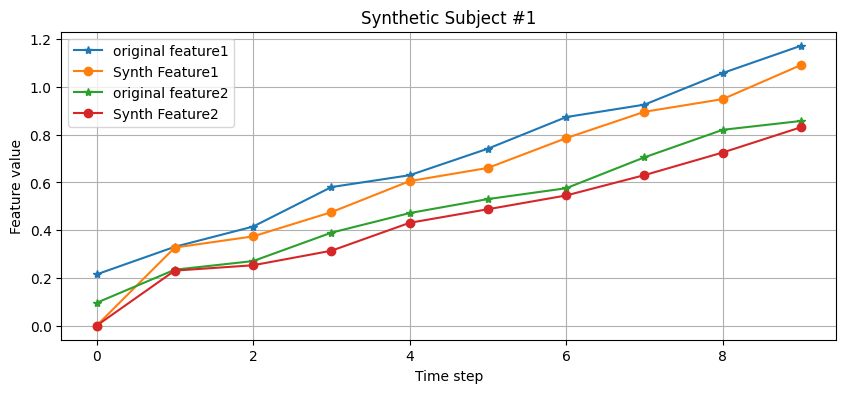

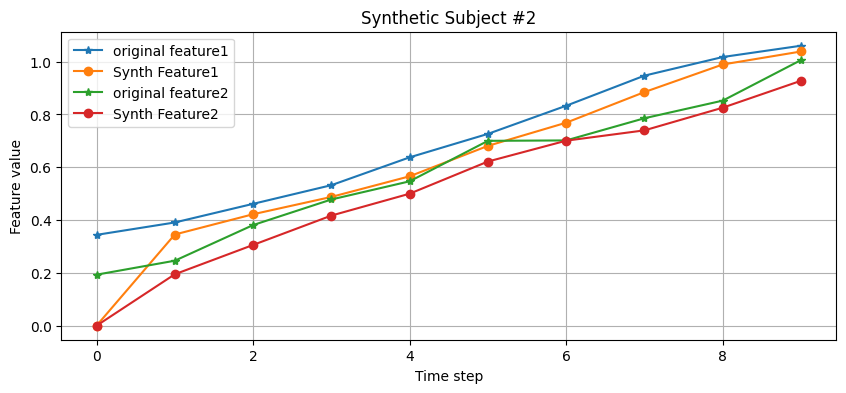

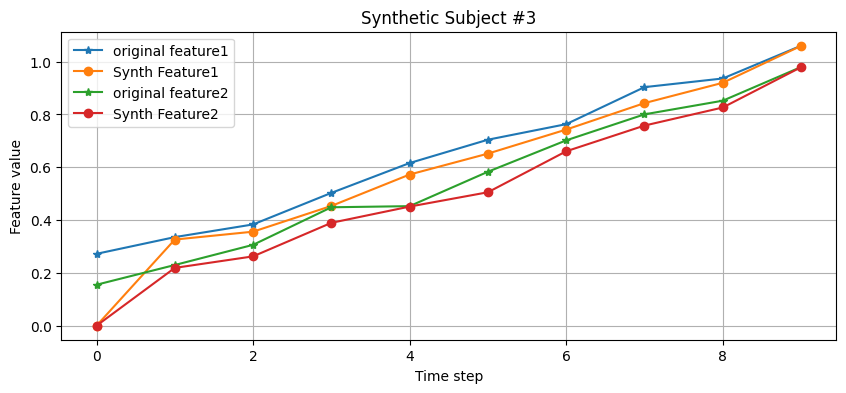

In [92]:
for subj in range(num_subjects):
    plt.figure(figsize=(10,4))
    for f in range(n_features):
        plt.plot(range(T),P[subj,:,f],marker='*',label=f"original feature{f+1}")
        plt.plot(range(T), synthetic_sequences[subj, :, f],
                 marker='o', label=f"Synth Feature{f+1}")
    plt.title(f"Synthetic Subject #{subj+1}")
    plt.xlabel("Time step")
    plt.ylabel("Feature value")
    plt.legend()
    plt.grid(True)
    plt.show()
